In [84]:
import cv2
import numpy as np
try:
  cv2.imshow()
  show=cv2.imshow
except:
  from google.colab.patches import cv2_imshow as show

In [85]:
pxls=100
blackPxls=0.5
th=90

In [86]:
def preprocess(img):
  img=np.array(img,np.int32)
  shp=(250,150)
  for r in range(shp[0]):
    for c in range((img.shape[1])):
      if r ==0 and c==0:
        img[r][c]=img[r][c]>th
      elif r==0 and c:
        img[r][c]=img[r][c-1]+(img[r][c]>th)
      elif c==0 and r:
        img[r][c]=img[r-1][c]+(img[r][c]>th)
      else:
        img[r][c]=img[r-1][c]+img[r][c-1]-img[r-1][c-1]+(img[r][c]>th)
  for r in range(shp[0],img.shape[0]):
    for c in range((shp[1])):
      if r ==0 and c==0:
        img[r][c]=img[r][c]>th
      elif r==0 and c:
        img[r][c]=img[r][c-1]+(img[r][c]>th)
      elif c==0 and r:
        img[r][c]=img[r-1][c]+(img[r][c]>th)
      else:
        img[r][c]=img[r-1][c]+img[r][c-1]-img[r-1][c-1]+(img[r][c]>th)
  return img
def ratioBlack(img,r,c,h,w):
  h-=1
  w-=1
  sm=0
  if r ==0 and c==0:
    sm= img[h][w]
  elif r==0 and c:
    sm= img[h][c+w]- img[h][c-1]
  elif c==0 and r:
    sm= img[r+h][w]-img[r-1][w]
  else:
    sm= img[r+h][c+w]-img[r-1][c+w]-img[r+h][c-1]+img[r-1][c-1]
  total=((h+1)*(w+1))
  return 1-sm/total;

In [87]:
def convoluteShort(on,kernelShape):
  
  if on.shape[0]<200 or on.shape[1]<200:
    return 1

  y_len=kernelShape[0]
  x_len=kernelShape[1]
  y_from,x_from=0,0
  done=False
  for y in range(100):
    for x in range(100):
      res=ratioBlack(on,y,x,y_len,x_len)
      if res>blackPxls:
        y_from,x_from=(y+y_len,x+x_len)
        done=True
        break
    if done:
      break

  # try:
  while(ratioBlack(on,y_from,x_from,5,5)>blackPxls):
    x_from+=2
  x_from-=2
  while(1-ratioBlack(on,y_from,x_from,2,pxls)>blackPxls):
    y_from+=1
  return y_from,x_from
  # except:
  #   return 2


def nextHorizontalShort(on,y_prev,x_prev):
  y_prev+=30
  y_from=y_prev
  x_from=x_prev
  while(ratioBlack(on,y_from,x_from,5,pxls)>blackPxls):
      y_from+=1
  while(1-ratioBlack(on,y_from,x_from,5,pxls)>blackPxls):
      y_from+=1
  return y_from,x_from

def nextVerticalShort(on,y_prev,x_prev):
  x_prev+=30
  y_from=y_prev
  x_from=x_prev
  while(ratioBlack(on,y_from,x_from,pxls,5)>blackPxls):
    x_from+=1
  while(1-ratioBlack(on,y_from,x_from,pxls,5)>blackPxls):
      x_from+=1
  return y_from,x_from

In [88]:
def rotate(img,angle):
  rows = img.shape[0]
  cols = img.shape[1]

  img_center = (cols / 2, rows / 2)
  M = cv2.getRotationMatrix2D(img_center, angle, 1)

  rotated_image = cv2.warpAffine(img, M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255,255,255))
  return rotated_image

In [89]:
import tensorflow as tf
from tensorflow import keras

In [90]:
def getAllCells(hori,ver,on):
  starts=[]
  for y in range(len(hori)-1):
    for x in range(len(ver)-1):
      leftTop=hori[y][0],ver[x][1]
      rightEnd=hori[y+1][0],ver[x+1][1]
      starts.append((leftTop,rightEnd))
  return starts

In [91]:
def giveHoriVer(marked):
  for ii in np.arange(0,5):
      for i in [ii,-(ii)]:
        global done
        done=False
        if i:
          timg=rotate(marked,i)
        else: 
          timg=marked
        img=preprocess(timg)
        try:
          leftEndpoint=convoluteShort(img,(30,30))
          horizontal=[leftEndpoint]
          vertical=[leftEndpoint]
          while(len(horizontal)<10):
            horizontal.append(nextHorizontalShort(img,horizontal[-1][0],horizontal[-1][1]))
          while(len(vertical)<8):
            vertical.append(nextVerticalShort(img,vertical[-1][0],vertical[-1][1]))
          done=True
          marked=timg
          break
        except:
          if ii==0:
            break
      if done :
        break
  # print(done)
  if not done:
    raise "not good image"
  else:
    return horizontal,vertical,marked

In [92]:
input_shape=(50,50)
num_classes=3

In [93]:
def extractImg(img,x1,y1,x2,y2):
  x1=x1-3
  y1=y1-3
  x2=x2+3
  y2=y2+3
  trimmed=img[y1:y2,x1:x2,np.newaxis]
  trimmed=tf.image.resize([trimmed],input_shape)
  return trimmed[0]

In [94]:
def getSubImgs(marked):
  horizontal,vertical,marked=giveHoriVer(marked)
  allBlocks=getAllCells(horizontal,vertical,marked)
  cells=marked.copy()
  subImgs=[]
  for lt,rb in allBlocks:
    cv2.rectangle(cells,lt[::-1],rb[::-1],100,2)
    subImgs.append(extractImg(marked,lt[1],lt[0],rb[1],rb[0]))
  subImgs=tf.convert_to_tensor(subImgs)
  return subImgs

In [95]:
kernelErode=np.ones((3,3),np.uint8)
def readImgGray(filename):
  imgGrid=cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
  imgGrid=cv2.threshold(imgGrid,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  imgGrid=cv2.erode(imgGrid,kernelErode)
  imgGrid=cv2.resize(imgGrid,(500,600),interpolation=cv2.INTER_AREA)
  return imgGrid

In [96]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer,Flatten,Dropout,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers
from sklearn.model_selection import train_test_split as tts

In [97]:
cellStates=['EMPTY','PRESENT','ABSENT']

In [98]:
def createData(imgName,stt):
  subImgs=[]
  states=[]
  assert len(imgName)==len(stt)
  for f,s in zip(imgName,stt):
    si=getSubImgs(readImgGray(f))
    sos=tf.constant(si.shape[0]*[s],tf.uint8)
    subImgs.extend(si)
    states.extend(sos)
  return subImgs,states

In [99]:
subImgs,states=createData(["grid.png","handA.png","handP.png","excel.png","excelA.png","priyaA.jpeg","priyaP.jpeg"],[0,2,1,1,2,2,1])

In [100]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer,Conv2D,BatchNormalization,Activation,AveragePooling2D,Dense,MaxPooling2D

In [101]:
def residual_block(X, num_filters: int, stride: int = 1, kernel_size: int = 3,
                   activation: str = 'relu', bn: bool = True, conv_first: bool = True):
    conv_layer = Conv2D(num_filters,
                        kernel_size=kernel_size,
                        strides=stride,
                        padding='same')
    # X = input
    if conv_first:
        X = conv_layer(X)
        if bn:
            X = BatchNormalization()(X)
        if activation is not None:
            X = Activation(activation)(X)
            X = Dropout(0.2)(X)
    else:
        if bn:
            X = BatchNormalization()(X)
        if activation is not None:
            X = Activation(activation)(X)
        X = conv_layer(X)

    return X

In [102]:
num_filters_in = 25
num_res_block=2
inputs = keras.Input(shape=input_shape+(1,))
X=Conv2D(num_filters_in,kernel_size=3,name="first_Conv")(inputs)
X=BatchNormalization()(X)
X=Activation('relu')(X)
X=MaxPooling2D()(X)
# ResNet V2 performs Conv2D on X before spiting into two path
X = residual_block(X=X, num_filters=num_filters_in, conv_first=False)

# Building stack of residual units
for stage in range(2):
    for unit_res_block in range(num_res_block):
        activation = 'relu'
        bn = True
        stride = 1
        # First layer and first stage
        if stage == 0:
            num_filters_out = num_filters_in * 4
            if unit_res_block == 0:
                activation = None
                bn = False
            # First layer but not first stage
        else:
            num_filters_out = num_filters_in * 2
            if unit_res_block == 0:
                stride = 2

        # bottleneck residual unit
        y = residual_block(X,
                           num_filters=num_filters_in,
                           kernel_size=1,
                           stride=stride,
                           activation=activation,
                           bn=bn,
                           conv_first=False)
        y = residual_block(y,
                           num_filters=num_filters_in,
                           conv_first=False)
        y = residual_block(y,
                           num_filters=num_filters_out,
                           kernel_size=1,
                           conv_first=False)
        if unit_res_block == 0:
            # linear projection residual shortcut connection to match
            # changed dims
            X = residual_block(X=X,
                               num_filters=num_filters_out,
                               kernel_size=1,
                               stride=stride,
                               activation=None,
                               bn=False)
        X = tf.keras.layers.add([X, y])
    num_filters_in = num_filters_out
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = AveragePooling2D()(X)
y = Flatten()(X)
y = Dense(512, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
# y = Dense(512, activation='relu')(y)
# y = BatchNormalization()(y)
# y = Dropout(0.5)(y)
outputs = Dense(num_classes,
                activation='softmax')(y)


In [103]:
def giveModel():
  return tf.keras.models.load_model("resConv4GridModel")

In [104]:
# lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [105]:
def createDataSet(X,y,is_training=False):
  ds=tf.data.Dataset.from_tensor_slices((X,y))
  ds=ds.batch(32).prefetch(32)
  if is_training:
    ds=ds.shuffle(32)
  return ds

In [106]:
# X=np.array(subImgs)
# y=np.array(states)

In [107]:
# X_train,X_test,y_train,y_test=tts(X,y,test_size=0.10,random_state=42,shuffle=True)

In [108]:
# train_ds=createDataSet(X_train,y_train,True)
# val_ds=createDataSet(X_test,y_test,True)

In [109]:
Attendance_model=giveModel()
# keras.utils.plot_model(Attendance_model)
# Attendance_model.summary()

In [110]:
# learning_rate= 5e-5
# Attendance_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

In [111]:
# with tf.device("/GPU:0"):
# history = Attendance_model.fit(train_ds, epochs=50,validation_data=val_ds,verbose=True)

In [112]:
# Attendance_model.evaluate(val_ds)

In [113]:
def imgWithLabel(img,model,labels):
  pred=tf.argmax(model.predict(np.array([img])),axis=1)[0].numpy()
  try:
    img=tf.image.grayscale_to_rgb(img)
    image = cv2.putText(img.numpy(), labels[pred][0], (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
  except:
    image = cv2.putText(img, labels[pred][0], (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
  return image

In [114]:
import matplotlib.pyplot as plt

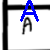

None

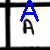

None

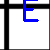

None

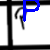

None

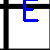

None

In [115]:
subImgs,states=createData(["grid.png","priyaA.jpeg","priyaP.jpeg"],[0,2,1])
sz=5
subImgs=tf.random.shuffle(subImgs)
for i in subImgs[:sz]:
  display(show(imgWithLabel(i,Attendance_model,cellStates)))

In [116]:
# Attendance_model.save("resConv4GridModel")

In [117]:
# !du -h resConv4GridModel

In [118]:
# !zip -r resConv4GridModel.zip resConv4GridModel

In [119]:
# keras.utils.plot_model(model)

In [120]:
# !zip -r resConv4GridModel resConv4GridModel

updating: resConv4GridModel/ (stored 0%)
updating: resConv4GridModel/saved_model.pb (deflated 91%)
updating: resConv4GridModel/assets/ (stored 0%)
updating: resConv4GridModel/keras_metadata.pb (deflated 95%)
updating: resConv4GridModel/variables/ (stored 0%)
updating: resConv4GridModel/variables/variables.data-00000-of-00001 (deflated 8%)
updating: resConv4GridModel/variables/variables.index (deflated 77%)
